# Set up

In [1]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import datetime
import cv2
from keras import backend as K
from keras.layers import Layer,InputSpec
from keras import layers
import keras.layers as kl
from glob import glob
from sklearn.metrics import roc_curve, auc
from keras.preprocessing import image
from tensorflow.keras.models import Sequential
from sklearn.metrics import roc_auc_score
from sklearn import preprocessing
from tensorflow.keras import callbacks 
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from  matplotlib import pyplot as plt
from tensorflow.keras import Model
from tensorflow.keras.layers import concatenate, Dense, Conv2D, MaxPooling2D, Flatten, Input, Activation, add, AveragePooling2D, BatchNormalization, Dropout
%matplotlib inline
import shutil
import scipy.io
from sklearn.metrics import  precision_score, recall_score, accuracy_score,classification_report ,confusion_matrix
from tensorflow.python.platform import build_info as tf_build_info
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
from sklearn.model_selection import train_test_split

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [2]:
tf.config.list_physical_devices('GPU')

[]

# Data Preparation

In [3]:
os.getcwd()
for x in range(3):
    os.chdir('..')
print (os.getcwd())

/Users/hoangminhthao/Documents/GitHub/HeartResearch


In [4]:
main_data_dir = os.getcwd() + "/Data set"
print(os.listdir(main_data_dir))

['.DS_Store', 'TrainingSet1', 'README.md', 'Label.csv', 'Output.png', 'TrainingSet3', 'TrainingSet2']


In [5]:
data_mat_files = glob(main_data_dir + "/TrainingSet*/*")

In [6]:
label_path = main_data_dir + "/Label.csv"
label_df = pd.read_csv(label_path)
print(label_df)

     Recording  First_label  Second_label  Third_label
0        A0001            5           NaN          NaN
1        A0002            1           NaN          NaN
2        A0003            2           NaN          NaN
3        A0004            2           NaN          NaN
4        A0005            7           NaN          NaN
...        ...          ...           ...          ...
6872     A6873            3           NaN          NaN
6873     A6874            8           NaN          NaN
6874     A6875            4           NaN          NaN
6875     A6876            2           NaN          NaN
6876     A6877            7           NaN          NaN

[6877 rows x 4 columns]


In [7]:
mat = scipy.io.loadmat(data_mat_files[0])
print(mat)

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Tue Dec 19 15:30:07 2017', '__version__': '1.0', '__globals__': [], 'ECG': array([[(array(['Female'], dtype='<U6'), array([[34]], dtype=uint8), array([[ 1.73768069e-02,  1.71725761e-02,  6.27266857e-03, ...,
                 5.66224605e-04, -3.98646404e-03, -4.72333344e-03],
               [ 2.73954729e-02,  1.91244035e-02,  8.96867281e-03, ...,
                 5.90927328e-02,  5.88357940e-02,  5.63322547e-02],
               [ 1.00186659e-02,  1.95182742e-03,  2.69600424e-03, ...,
                 5.85265082e-02,  6.28222581e-02,  6.10555882e-02],
               ...,
               [ 1.55362648e-01,  2.27003440e-01,  2.08681742e-01, ...,
                -1.75072873e-02, -2.21225776e-02, -2.85125191e-02],
               [ 4.89187271e-01,  6.99974197e-01,  6.39584023e-01, ...,
                 1.08587053e-01,  9.61002216e-02,  1.01143936e-01],
               [ 1.14240268e+00,  1.61560312e+00,  1.44965444e+00, ...,
   

In [8]:
def data_extract(signal_raw_list, label_raw, min_len = 3000):
    signal_list = []
    label_list = []
    
    for signal in signal_raw_list:
        mat = scipy.io.loadmat(signal)
        signal_list.append(mat['ECG'][0][0][2][:,:min_len])
        
        signal_number = signal.split('/')[-1].split('.')[0]
        label_list.append(label_raw[label_raw['Recording'] == signal_number]['First_label'].values[0])
    
    le = preprocessing.LabelEncoder()
    le.fit(label_list)
    labels = le.transform(label_list)
    labels = tf.keras.utils.to_categorical(labels)
    return (np.array(signal_list), np.array(labels))

In [9]:
signal, label = data_extract(data_mat_files, label_df)

In [10]:
print(signal.shape)
print(label.shape)

(6877, 12, 3000)
(6877, 9)


# Data

In [11]:
train_signal, test_signal, train_label, test_label = train_test_split(signal, label, test_size = 0.2, random_state=42)

# Model

In [12]:
class Model1_LSTM(tf.keras.Model):
    def __init__(self, activation, rate, units_LSTM, units_dense, recurrent_dropout, dropout):
        super(Model1_LSTM, self).__init__()
        unit_dense1, unit_dense2 = units_dense
        act1, act2 = activation
        self.LSTM = layers.LSTM(units=units_LSTM, 
                                activation='tanh', 
                                recurrent_activation='hard_sigmoid', 
                                recurrent_dropout=recurrent_dropout,
                                dropout=dropout)
        self.dense1 = Dense(units=unit_dense1, 
                            activation=act1)
        self.drop = Dropout(rate)
        self.dense2 = Dense(units=unit_dense2,
                            activation=act2)

    def call(self, input):
        x = self.LSTM(input)
        x = self.dense1(x)
        x = self.drop(x)
        x = self.dense2(x)

        return x

# Training

In [13]:
basemodel = Model1_LSTM(units_dense = (64, 9), 
                        activation = ('relu', 'softmax'), 
                        rate = 0.5, 
                        units_LSTM= 64, 
                        recurrent_dropout= 0.2, 
                        dropout=0.2)
                        
Input = tf.keras.Input(shape= (12,3000))
# input = train_signal
output = basemodel(Input)
model = tf.keras.Model(Input, output)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 12, 3000)]        0         
                                                                 
 model1_lstm (Model1_LSTM)   (None, 9)                 789385    
                                                                 
Total params: 789,385
Trainable params: 789,385
Non-trainable params: 0
_________________________________________________________________


In [14]:
model.compile(optimizer='adam', loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False), metrics = 'accuracy')

In [15]:
model.fit(train_signal, train_label, epochs = 10)

Epoch 1/10


2022-11-29 19:21:19.775981: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


172/172 [==============================] - 8s 39ms/step - loss: 2.1316 - accuracy: 0.1900
Epoch 2/10
172/172 [==============================] - 7s 41ms/step - loss: 1.9317 - accuracy: 0.2856
Epoch 3/10
172/172 [==============================] - 7s 40ms/step - loss: 1.7656 - accuracy: 0.3607
Epoch 4/10
172/172 [==============================] - 7s 41ms/step - loss: 1.5371 - accuracy: 0.4534
Epoch 5/10
172/172 [==============================] - 7s 42ms/step - loss: 1.2895 - accuracy: 0.5541
Epoch 6/10
172/172 [==============================] - 7s 40ms/step - loss: 1.0447 - accuracy: 0.6461
Epoch 7/10
172/172 [==============================] - 7s 41ms/step - loss: 0.8199 - accuracy: 0.7324
Epoch 8/10
172/172 [==============================] - 7s 40ms/step - loss: 0.6662 - accuracy: 0.7879
Epoch 9/10
172/172 [==============================] - 7s 41ms/step - loss: 0.5338 - accuracy: 0.8309
Epoch 10/10
172/172 [==============================] - 7s 40ms/step - loss: 0.4514 - accuracy: 0.8617


In [16]:
prediction = model.predict(test_signal)

43/43 [==============================] - 1s 8ms/step


# Classification report

In [17]:
print(classification_report(np.argmax(test_label,axis=1),np.argmax(prediction, axis=1)))
y_true = np.argmax(test_label,axis=1)
y_pred = np.argmax(prediction, axis=1)

              precision    recall  f1-score   support

           0       0.31      0.34      0.32       185
           1       0.20      0.17      0.18       232
           2       0.18      0.15      0.16       148
           3       0.11      0.05      0.07        38
           4       0.32      0.40      0.36       337
           5       0.09      0.12      0.11        96
           6       0.23      0.20      0.21       138
           7       0.17      0.16      0.17       169
           8       0.12      0.06      0.08        33

    accuracy                           0.24      1376
   macro avg       0.19      0.18      0.18      1376
weighted avg       0.23      0.24      0.23      1376



# Confusion Matrix Metrics

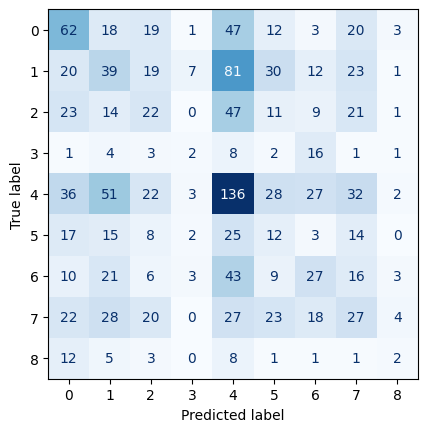

In [18]:
disp = ConfusionMatrixDisplay.from_predictions(np.argmax(test_label,axis=1),np.argmax(prediction, axis=1), colorbar=None, cmap='Blues')

# Weighted, Macro, Micro, ROC AUC

In [19]:
print("Precision: "+ str(precision_score(y_true, y_pred, average='weighted')))
print("Recall: "+ str(recall_score(y_true, y_pred, average='weighted')))
print("Accuracy: " + str(accuracy_score(y_true, y_pred)))
print("weighted Roc score: " + str(roc_auc_score(y_test, y_pred, multi_class='ovr',average='weighted')))

Precision: 0.23027732355481947
Recall: 0.23909883720930233
Accuracy: 0.23909883720930233


NameError: name 'y_test' is not defined

In [28]:
print("Precision: "+ str(precision_score(np.argmax(test_label,axis=1),np.argmax(prediction, axis=1), average='macro')))
print("Recall: "+ str(recall_score(np.argmax(test_label,axis=1),np.argmax(prediction, axis=1), average='macro')))
print("Accuracy: " + str(accuracy_score(np.argmax(test_label,axis=1),np.argmax(prediction, axis=1))))
print("weighted Roc score: " + str(roc_auc_score(np.argmax(test_label,axis=1),prediction, multi_class='ovo',average='macro')))

Precision: 0.1930535342880291
Recall: 0.18323346555512443
Accuracy: 0.23909883720930233
weighted Roc score: 0.6125827538430415


In [ ]:
print("Precision: "+ str(precision_score(y_true, y_pred, average='micro')))
print("Recall: "+ str(recall_score(y_true, y_pred, average='micro')))
print("Accuracy: " + str(accuracy_score(y_true, y_pred)))
tpr={}
fpr={}
roc_auc={}
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
print("Micro Roc score: " + str(roc_auc["micro"]))

In [ ]:
print(fpr["micro"])
print(tpr["micro"])

In [ ]:
fpr = {}
tpr = {}
roc_auc = {}
for i in range(7):
    r = roc_auc_score(y_test[:, i], y_prob[:, i])
    print("The ROC AUC score of "+targetnames[i]+" is: "+str(r))

In [ ]:
# Compute ROC curve and ROC area for each class
fpr = {}
tpr = {}
roc_auc = dict()
for i in range(7):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_prob[:, i], drop_intermediate=False)
    roc_auc[i] = auc(fpr[i], tpr[i])

In [ ]:
sns.set(font_scale=0.7)
plt.plot(fpr[0], tpr[0],'v-',label='akiec: ROC curve of (area = %0.2f)' % roc_auc[0])
plt.plot(fpr[1], tpr[1],'c',label='bcc: ROC curve of (area = %0.2f)' % roc_auc[1])
plt.plot(fpr[2], tpr[2],'b',label='bkl: ROC curve of (area = %0.2f)' % roc_auc[2])
plt.plot(fpr[3], tpr[3],'g',label='df: ROC curve of (area = %0.2f)' % roc_auc[3])
plt.plot(fpr[4], tpr[4],'y',label='mel: ROC curve of (area = %0.2f)' % roc_auc[4])
plt.plot(fpr[5], tpr[5],'o-',label='nv: ROC curve of (area = %0.2f)' % roc_auc[5])
plt.plot(fpr[6], tpr[6],'r',label='vasc: ROC curve of (area = %0.2f)' % roc_auc[6])

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic of %s'%targetnames[i])
plt.legend(loc="lower right")
plt.show()